In [45]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import erf
from scipy.special import logsumexp

In [218]:
def truncnorm(xx, mu, sigma, high, low):
    """ ripped from gwpop v1.1.1 -- Colm's later version has a nan switch
        that breaks autodiff!
    """
    norm = 2**0.5 / np.pi**0.5 / sigma
    norm /= erf((high - mu) / 2**0.5 / sigma) + erf(
        (mu - low) / 2**0.5 / sigma
    )
    prob = np.exp(-np.power(xx - mu, 2) / (2 * sigma**2))
    prob *= norm
    prob *= (xx <= high) & (xx >= low)
    return prob

I'll generate an equal number of VT samples from each subpopulation of:
- isotropic
- near-peak ($\lesssim 20^\circ$)
- hyper-peak ($\lesssim 10^\circ$)

But how do we choose how many of these, in each subpopulation, to run parameter estimation on?

We want to do parameter estimation on $\lesssim 10^3$ sources and we want catalogs of $\cal O(10^2)$ sources; so we want a reweighting efficiency of $>10\%$.

In [ ]:
rng = np.random.default_rng(1)
xi_draw = 0.9
low = 0.99

def draw(low):
    u = rng.uniform()
    if u < xi_draw:
        t1 = rng.uniform(low=low, high=1)
        t2 = rng.uniform(low=low, high=1)
    else:
        t1 = rng.uniform(low=-1, high=1)
        t2 = rng.uniform(low=-1, high=1)
    return t1, t2

In [201]:
taus = np.stack([ draw() for _ in range(10_000) ])

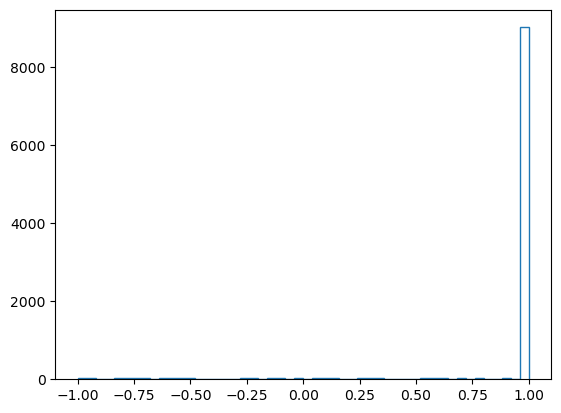

In [202]:
fig, ax = plt.subplots()
ax.hist(taus[:, 0], histtype='step', bins=50);

In [203]:
pdraw = (1 - xi_draw) / 4 + xi_draw / (1 - low) / (1 - low)

In [204]:
log_pdraw = np.log(pdraw)

In [205]:
xi = 0.9

def log_iso_gauss(cos_tau_1, cos_tau_2, xi, mu, sigma):
    return logsumexp(np.array([
        np.log((1 - xi) / 4),
        (
            np.log(xi)
            + np.log(truncnorm(cos_tau_1, mu, sigma, high=1, low=-1))
            + np.log(truncnorm(cos_tau_2, mu, sigma, high=1, low=-1))
        )
    ]))

def log_iso_gauss_marg(cos_tau, xi, mu, sigma):
    return logsumexp(np.array([
        np.log((1 - xi) / 2),
        (
            np.log(xi)
            + np.log(truncnorm(cos_tau, mu, sigma, high=1, low=-1))
        )
    ])) 

In [212]:
xi = 0.9
mu = 1
sigma = 1e-4

log_ptarget = np.array([
    log_iso_gauss(
        ct1,
        ct2,
        xi,
        mu,
        sigma
    )
    for ct1, ct2 in taus
])

/tmp/ipykernel_2846558/2580263453.py:8: RuntimeWarning: divide by zero encountered in log
  + np.log(truncnorm(cos_tau_1, mu, sigma, high=1, low=-1))
/tmp/ipykernel_2846558/2580263453.py:9: RuntimeWarning: divide by zero encountered in log
  + np.log(truncnorm(cos_tau_2, mu, sigma, high=1, low=-1))


In [213]:
log_weights = log_ptarget - log_pdraw

In [214]:
n = len(log_weights)
log_evidence = logsumexp(log_weights) - np.log(n)

log_norm_weights = log_weights - log_evidence - np.log(n)
neff = np.exp(-logsumexp(2 * log_norm_weights))

In [215]:
neff

np.float64(275.3396664226947)

In [216]:
u = np.random.uniform(size=(10_000,))
mask = u < np.exp(log_weights - np.max(log_weights))
taus[mask].shape

(157, 2)

/tmp/ipykernel_2846558/2580263453.py:18: RuntimeWarning: divide by zero encountered in log
  + np.log(truncnorm(cos_tau, mu, sigma, high=1, low=-1))


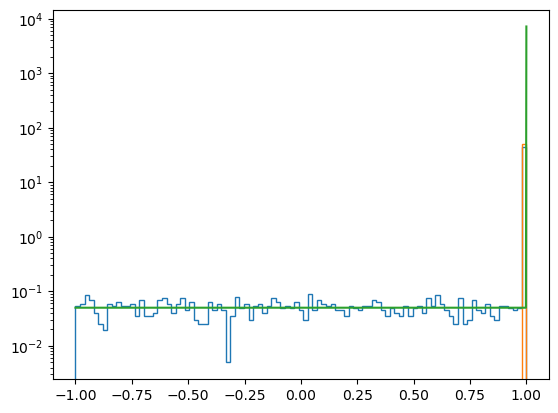

In [217]:
test_cts = np.linspace(-1, 1, 1_000)
log_ptest = np.vectorize(lambda x: log_iso_gauss_marg(x, xi, mu, sigma))(test_cts)

ks = dict(histtype='step', bins=np.linspace(-1, 1, 100), density=True)

fig, ax = plt.subplots()
ax.hist(taus[:, 0], **ks)
ax.hist(taus[mask][:, 0], **ks)
ax.plot(test_cts, np.exp(log_ptest))

ax.set_yscale('log')